# PIGA
PIGA is one of several proteins required for the first step of GPI anchor biosynthesis.
[multiple congenital anomalies-hypotonia-seizures syndrome-2 (MCAHS2)](https://omim.org/entry/300868)
and
that neurodevelopmental disorder with epilepsy and hemochromatosis (NEDEPH)](https://omim.org/entry/301072) is caused by hemizygous mutation in the PIGA gene.

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2023-10-09')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2023-10-09
Using gpsea version 0.7.1.dev0


### PIGA
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for PIGA.

In [2]:
gene_symbol = 'PIGA'
mane_tx_id = 'NM_002641.4'
mane_protein_id = 'NP_002632.1' # phosphatidylinositol N-acetylglucosaminyltransferase subunit A isoform 1 [Homo sapiens]

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store('0.1.20') as ps:
        phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))


cohort_creator = configure_caching_cohort_creator(hpo)
cohort, qc_results = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
qc_results.summarize()

Individuals Processed: 100%|██████████| 27/27 [00:00<00:00, 444.79individuals/s]
Validated under permissive policy
Showing errors and warnings
Phenopackets
  patient #2
    phenotype-features
      #0
       warnings:
       ·`time_element` is in currently unsupported format `ontology_class`
    diseases
      #0
       warnings:
       ·`time_element` is in currently unsupported format `ontology_class`
  patient #3
    diseases
      #0
       warnings:
       ·`time_element` is in currently unsupported format `ontology_class`
  patient #14
    phenotype-features
      #0
       warnings:
       ·`time_element` is in currently unsupported format `ontology_class`
    diseases
      #0
       warnings:
       ·`time_element` is in currently unsupported format `ontology_class`


In [5]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

HPO Term,ID,Seen in n individuals
Global developmental delay,HP:0001263,12
Seizure,HP:0001250,10
Hypoplasia of the corpus callosum,HP:0002079,9
Hypsarrhythmia,HP:0002521,9
Flexion contracture,HP:0001371,8
Elevated circulating alkaline phosphatase concentration,HP:0003155,8
Generalized myoclonic seizure,HP:0002123,7
Cerebral visual impairment,HP:0100704,7
Abnormality of the face,HP:0000271,6
Hypotonia,HP:0001252,6


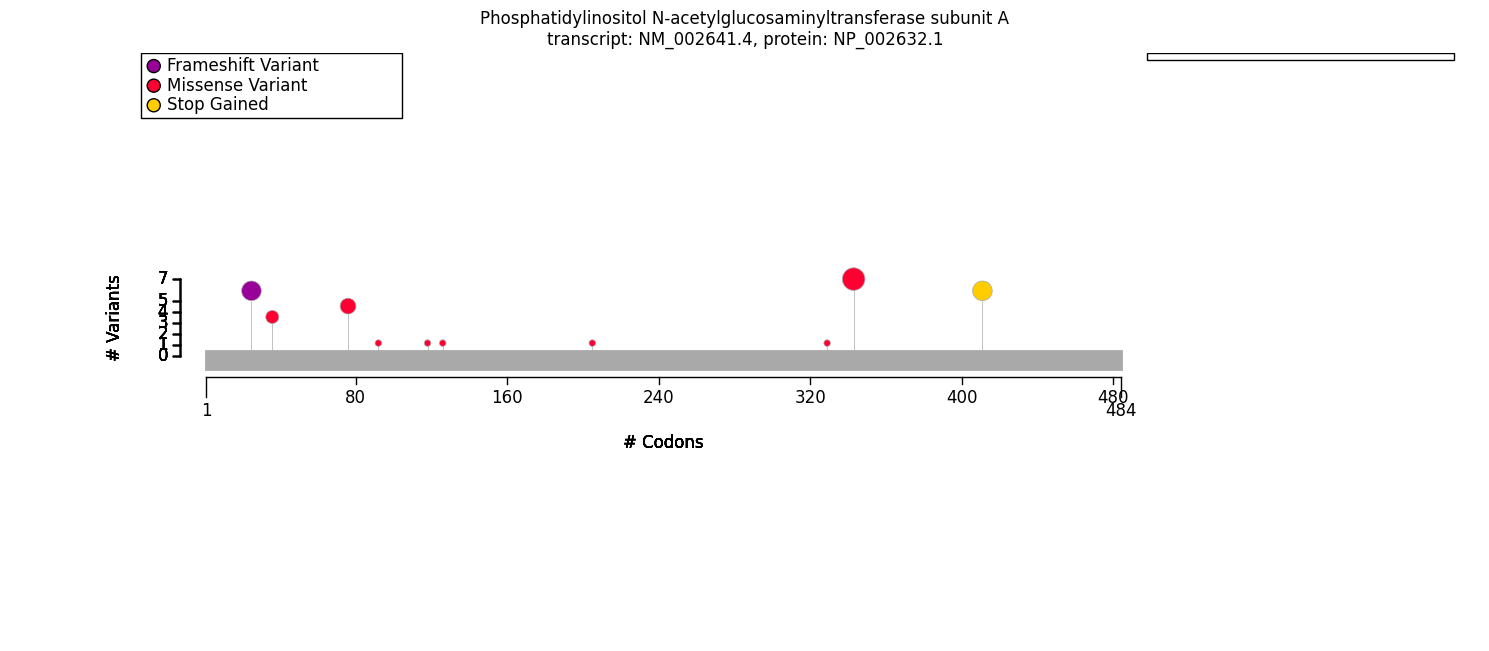

In [6]:
from gpsea.model.genome import GRCh38
from gpsea.model import ProteinMetadata
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)
"""
protein_meta = ProteinMetadata.from_uniprot_json(
        protein_id=mane_protein_id,
        label="NKX6-2",
        uniprot_json="Q9C056.json",
        protein_length=550,
)
"""

fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
fig.tight_layout()

In [8]:
from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest

pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)
len(pheno_predicates)
from gpsea.analysis.mtc_filter import HpoMtcFilter
mtc_filter = HpoMtcFilter.default_filter(
    hpo=hpo,
     term_frequency_threshold=0.2,
)
mtc_correction = 'fdr_bh'
mtc_alpha = 0.05
from gpsea.analysis.pcats.stats import FisherExactTest

count_statistic = FisherExactTest()
from gpsea.analysis.pcats import HpoTermAnalysis

analysis = HpoTermAnalysis(
    count_statistic=count_statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
    mtc_alpha=mtc_alpha,
)

In [10]:
from gpsea.model.genome import Region
from gpsea.analysis.predicate.genotype import VariantPredicates, monoallelic_predicate

n_term = VariantPredicates.region(region=Region(0,200), tx_id=mane_tx_id)

n_term_predicate = monoallelic_predicate(a_predicate=n_term, 
                                         b_predicate=~ n_term, 
                                         a_label="1-100",
                                         b_label="100+")

In [11]:
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=n_term_predicate,
    pheno_predicates=pheno_predicates,
)
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
viewer.process(result)

Code,Reason,Count
HMF03,Skipping term because of a child term with the same individual counts,8
HMF08,Skipping general term,109
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,411


In [12]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=result)

Allele group                                        1-100           100+  \
                                                    Count Percent  Count   
Flexion contracture [HP:0001371]                      1/3     33%  10/12   
Hypotonia [HP:0001252]                                5/6     83%    7/7   
Hyperreflexia [HP:0001347]                            1/3     33%    6/9   
Abnormal cerebral white matter morphology [HP:0...    4/4    100%    7/7   
Abnormal cerebral morphology [HP:0002060]             5/5    100%  12/12   
Abnormal forebrain morphology [HP:0100547]            5/5    100%  12/12   
Abnormal brain morphology [HP:0012443]                5/5    100%  12/12   
Morphological central nervous system abnormalit...    5/5    100%  12/12   
Aplasia/Hypoplasia of the cerebrum [HP:0007364]       3/3    100%  11/11   
Aplasia/Hypoplasia involving the central nervou...    4/4    100%  12/12   
Motor seizure [HP:0020219]                            6/6    100%    6/6   
Seizure [HP:0001250]                                12/12    100%  13/13   
Joint contracture [HP:0034392]                        1/1    100%  10/10   
Abnormality of joint mobility [HP:0011729]            1/1    100%  10/10   
EEG with generalized epileptiform discharges [H...    9/9    100%    5/5   
Abnormal oral cavity morphology [HP:0000163]          1/1    100%  10/10   
Abnormal oral morphology [HP:0031816]                 1/1    100%  10/10   
Abnormal muscle tone [HP:0003808]                     6/6    100%  10/10   
Global developmental delay [HP:0001263]               8/8    100%    5/5   
Neurodevelopmental delay [HP:0012758]                 8/8    100%    7/7   
Neurodevelopmental abnormality [HP:0012759]         13/13    100%    9/9   
Spasticity [HP:0001257]                               3/5     60%    5/7   
Upper motor neuron dysfunction [HP:0002493]           4/4    100%    7/7   

Allele group                                                                   \
                                                   Percent Corrected p values   
Flexion contracture [HP:0001371]                       83%                1.0   
Hypotonia [HP:0001252]                                100%                1.0   
Hyperreflexia [HP:0001347]                             67%                1.0   
Abnormal cerebral white matter morphology [HP:0...    100%                1.0   
Abnormal cerebral morphology [HP:0002060]             100%                1.0   
Abnormal forebrain morphology [HP:0100547]            100%                1.0   
Abnormal brain morphology [HP:0012443]                100%                1.0   
Morphological central nervous system abnormalit...    100%                1.0   
Aplasia/Hypoplasia of the cerebrum [HP:0007364]       100%                1.0   
Aplasia/Hypoplasia involving the central nervou...    100%                1.0   
Motor seizure [HP:0020219]                            100%                1.0   
Seizure [HP:0001250]                                  100%                1.0   
Joint contracture [HP:0034392]                        100%                1.0   
Abnormality of joint mobility [HP:0011729]            100%                1.0   
EEG with generalized epileptiform discharges [H...    100%                1.0   
Abnormal oral cavity morphology [HP:0000163]          100%                1.0   
Abnormal oral morphology [HP:0031816]                 100%                1.0   
Abnormal muscle tone [HP:0003808]                     100%                1.0   
Global developmental delay [HP:0001263]               100%                1.0   
Neurodevelopmental delay [HP:0012758]                 100%                1.0   
Neurodevelopmental abnormality [HP:0012759]           100%                1.0   
Spasticity [HP:0001257]                                71%                1.0   
Upper motor neuron dysfunction [HP:0002493]           100%                1.0   

Allele group                                                  
          